# Introduction to pyro

Following the tutorial [here](https://pyro.ai/examples/intro_part_ii.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from torch.distributions import constraints

pyro.set_rng_seed(101)

Consider a scale which noisily measures the weight of the object placed on it. A model could be:

- $w = $ weight
- $y = $ measurement of weight from a noisy scale
- $\sigma^2 = $ variance of the noisy scale

$$y \sim \text{Normal}(w, \sigma^2)$$

and suppose that $\sigma$ is known to be $\sigma = \sqrt{0.75}$.

We seek to infer the latent model parameter $w$ from data. We form a prior on $w$ as

$$w \sim \text{Normal}(\mu_0, \sigma_0^2)$$

Furthermore, suppose we have a single observation, that $\hat{y}=9.5$. Therefore, we have a model likelihood as a normal distribution with unknown mean and known variance, with a normal conjugate prior. The posterior may be written analytically as

$$w|\hat{y}, \mu_0, \sigma_0, \sigma \sim \text{Normal}(\mu^*, {\sigma^*}^2)$$

where $\mu^*$ and $\sigma^*$ can be written exclusively in terms of $\hat{y}, \mu_0, \sigma_0, \sigma$.

In [2]:
def exact_posterior(datum, mu_prior, sigma_prior, sigma_measurement):
    var_prior = sigma_prior**2
    var_measurement = sigma_measurement**2
    
    s1 = 1./(1./var_prior + 1./var_measurement)
    s2 = mu_prior/var_prior
    s3 = datum/var_measurement
    
    mu_posterior = s1*(s2 + s3)
    sigma_posterior = np.sqrt(1./(1./var_prior + 1./var_measurement))
    
    return mu_posterior, sigma_posterior

In [3]:
SIGMA_MEASUREMENT = 0.75  # known

In [4]:
def scale(mu_prior, sigma_prior):
    weight = pyro.sample("weight", dist.Normal(mu_prior, sigma_prior))
    return pyro.sample("measurement", dist.Normal(weight, SIGMA_MEASUREMENT))

In [5]:
datum = 9.5
mu_prior = 8.5
sigma_prior = 1

mu_posterior_exact, sigma_posterior_exact = exact_posterior(datum, mu_prior, sigma_prior, SIGMA_MEASUREMENT)

Now, let's try and do this with stochastic variational inference in pyro using stochastic gradient descent.

In [6]:
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(datum)})

In [7]:
def scale_guide(mu_prior, sigma_prior):
    a = pyro.param("a", torch.tensor(mu_prior))
    b = pyro.param("b", torch.tensor(sigma_prior), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

In [8]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_guide,
                     optim=pyro.optim.Adam({"lr": 0.003}),
                     loss=pyro.infer.Trace_ELBO())

losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(mu_prior, sigma_prior))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

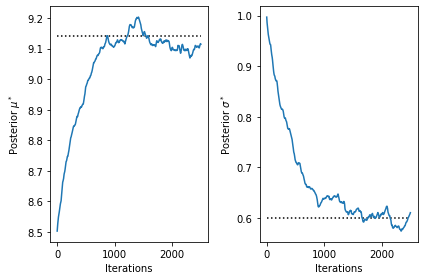

In [9]:
fig, axs = plt.subplots(1,2)

ax = axs[0]
ax.plot([0,num_steps],[mu_posterior_exact, mu_posterior_exact], 'k:')
ax.plot(a)
ax.set_ylabel('Posterior $\mu^*$')
ax.set_xlabel('Iterations')

ax = axs[1]
ax.plot([0,num_steps],[sigma_posterior_exact, sigma_posterior_exact], 'k:')
ax.plot(b)
ax.set_ylabel('Posterior $\sigma^*$')
ax.set_xlabel('Iterations')

plt.tight_layout()

So you can see that SVI obtains parameters very close to the true parameters of the posterior distribution. This is to be expected, since the target distribution and the guide are of the same family.

Since this is variational inference, we also obtain an estimate of the model evidence -- the evidence lower bound (ELBO)

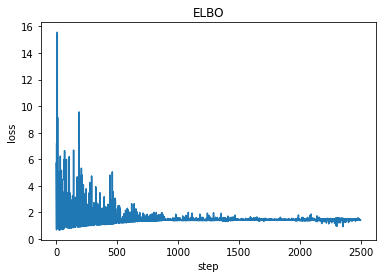

In [10]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss");